# Knapsack

In [1]:
title = 'Knapsack'

In [2]:
import mlrose_hiive

import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
eval_count = 0
>>> weights = [10, 5, 2, 8, 15]
>>> values = [1, 2, 3, 4, 5]
>>> max_weight_pct = 0.6
>>> fitness = mlrose.Knapsack(weights, values, max_weight_pct)
>>> state = np.array([1, 0, 2, 1, 0])
>>> fitness.evaluate(state)

def flip_flop(state):
    global eval_count
    
    fitness = mlrose_hiive.FlipFlop()
    
    eval_count += 1
    
    return fitness.evaluate(state)

ffn_flipflop = mlrose_hiive.CustomFitness(flip_flop)

print(flip_flop(np.array([0, 1, 0, 1, 1, 1, 1])))

3


In [7]:
np.random.seed(1)
input_size = np.arange(6, 20, 4, dtype=np.int)

eval_cnt_df = pd.DataFrame()
eval_cnt_df['input_size'] = input_size
eval_cnt_rhc = []
eval_cnt_sa = []
eval_cnt_ga = []
eval_cnt_mimic = []

eval_time_df = pd.DataFrame()
eval_time_df['input_size'] = input_size
eval_time_rhc = []
eval_time_sa = []
eval_time_ga = []
eval_time_mimic = []

fitness_curve = {}

schedule=mlrose_hiive.ExpDecay() ## Simulated Annealing
# schedule=mlrose_hiive.ExpDecay(exp_const=.001, init_temp=2)

for n in input_size:
    ## initialize problem
    init_state = np.random.randint(2, size=n)
    problem = mlrose_hiive.DiscreteOpt(length=len(init_state), fitness_fn=ffn_flipflop, 
                                 maximize=True)
    
    ## Random Hill Climbing
    eval_count = 0
    begin = datetime.now()
    rhc_state, rhc_fitness, rhc_curve = mlrose_hiive.random_hill_climb(problem, 
                                                                 max_attempts=20, 
                                                                 max_iters=10000,
                                                                 restarts=0,
                                                                 init_state=init_state,
                                                                 curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_rhc.append(dt.total_seconds())
    eval_cnt_rhc.append(eval_count)

    ## Simulated Annealing
    eval_count = 0
    begin = datetime.now()
    sa_state, sa_fitness, sa_curve = mlrose_hiive.simulated_annealing(problem,
                                                                   schedule=schedule,
                                                                   max_attempts=40, 
                                                                   max_iters=10000, 
                                                                   init_state=init_state,
                                                                   curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_sa.append(dt.total_seconds())
    eval_cnt_sa.append(eval_count)
    
    ## Genetic Algorithm
    eval_count = 0
    pop_size = int(n * 5)
    mute_prob = 0.1 #0.025
    begin = datetime.now()
    ga_state, ga_fitness, ga_curve =  mlrose_hiive.genetic_alg(problem, 
                                                               pop_size=pop_size,
                                                               mutation_prob=mute_prob, 
                                                               max_attempts=20,
                                                               max_iters=2000,
                                                               curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_ga.append(dt.total_seconds())
    eval_cnt_ga.append(eval_count)
    
    ## MIMIC
    eval_count = 0
    pop_size = int(n * 5)
    keep_pct = 0.25
    begin = datetime.now()
    mimic_state, mimic_fitness, mimic_curve = mlrose_hiive.mimic(problem, 
                                                                 pop_size=pop_size,
                                                                 keep_pct=keep_pct, 
                                                                 max_attempts=30,
                                                                 max_iters=500,
                                                                 curve=True)
    end = datetime.now()
    
    dt = end - begin
    eval_time_mimic.append(dt.total_seconds())
    eval_cnt_mimic.append(eval_count)


fitness_curve['rhc'] = rhc_curve
fitness_curve['sa']  = sa_curve
fitness_curve['ga']  = ga_curve
fitness_curve['mimic'] = mimic_curve

eval_cnt_df['rhc'] = eval_cnt_rhc
eval_cnt_df['sa']  = eval_cnt_sa
eval_cnt_df['ga']  = eval_cnt_ga
eval_cnt_df['mimic'] = eval_cnt_mimic

eval_time_df['rhc'] = eval_time_rhc
eval_time_df['sa']  = eval_time_sa
eval_time_df['ga']  = eval_time_ga
eval_time_df['mimic'] = eval_time_mimic

In [8]:
eval_cnt_df

,input_size,rhc,sa,ga,mimic
0,6,26,371,683,993
1,10,28,248,1583,1633
2,14,44,1296,1563,2345
3,18,43,671,2824,3005


[Text(0, 0.5, 'Number of Evaluations'), Text(0.5, 0, 'Input Sizes')]

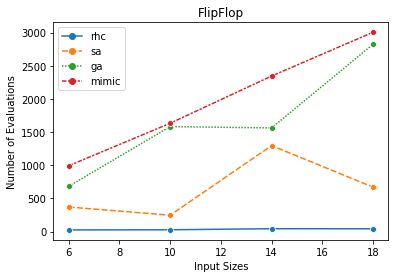

In [9]:
df = eval_cnt_df.set_index('input_size')
ax = sns.lineplot(data=df, markers=['o']*4)

ax.set_title(title)
ax.set(xlabel='Input Sizes',ylabel='Number of Evaluations')

In [10]:
eval_time_df

,input_size,rhc,sa,ga,mimic
0,6,0.002027,0.021946,0.052647,0.422404
1,10,0.001320,0.012505,0.138670,1.123904
2,14,0.002524,0.080792,0.153411,2.278752
3,18,0.002936,0.049424,0.304453,3.583448


[Text(0, 0.5, 'Time (s)'), Text(0.5, 0, 'Input Sizes')]

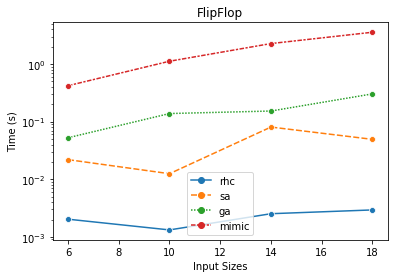

In [11]:
df = eval_time_df.set_index('input_size')
ax = sns.lineplot(data=df, markers=['o']*4)

ax.set_title(title)
ax.set_yscale('log')
ax.set(xlabel='Input Sizes', ylabel='Time (s)')

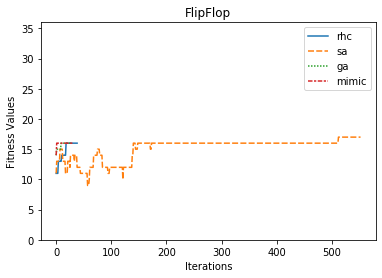

In [12]:
## Fitness Convergence Analysis
labels = ['rhc', 'sa', 'ga', 'mimic']

ax = sns.lineplot(data=[rhc_curve, sa_curve, ga_curve, mimic_curve])
ax.set_ylim(0, 36)
ax.set_title(title)
ax.set(xlabel='Iterations',ylabel='Fitness Values')

legend = ax.get_legend()
for handle,l in zip(legend.texts, labels):
    handle.set_text(l)


In [15]:
print(title, 'bit array size:%d'%len(rhc_state))
print('rhc:   {0:5.1f}'.format(rhc_fitness), rhc_state)
print('sa:    {0:5.1f}'.format(sa_fitness), sa_state)
print('ga:    {0:5.1f}'.format(ga_fitness), ga_state)
print('mimic: {0:5.1f}'.format(mimic_fitness), mimic_state)

FlipFlop bit array size:18
rhc:    16.0 [1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1]
sa:     17.0 [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0]
ga:     16.0 [1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1]
mimic:  16.0 [0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0]
